In [ ]:
%pip install tqdm
%pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
import wandb
import os
import torch
from PIL import Image
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torchvision.datasets as datasets
from scipy.stats import gaussian_kde
from scipy.stats import norm
from random import randint

In [ ]:
wandb.login(key=)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name':'loss',
    'goal':'minimize'
}
sweep_config['metric']=metric

parameters_dict = {
    'latent_dim': {
        'value':2},
    'num_epochs':{
        'value':20},
    'batch_size':{
        'value':16},
    'learning_rate':{
        'value':3.5e-4},
    'alpha':{
        'value':0.7},
    'lbd':{
        'value':100},
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='Bivariate Info Tuned')
project='Bivariate Info Tuned'
folder_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}"
os.makedirs(folder_path)

Create sweep with ID: wxhn3pdc
Sweep URL: https://wandb.ai/t-a-emm-20/Bivariate%20Info%20Tuned/sweeps/wxhn3pdc


100%|██████████| 9912422/9912422 [00:00<00:00, 76458125.28it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40018399.02it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31921070.25it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20797520.49it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



torch.Size([50000, 1, 28, 28])


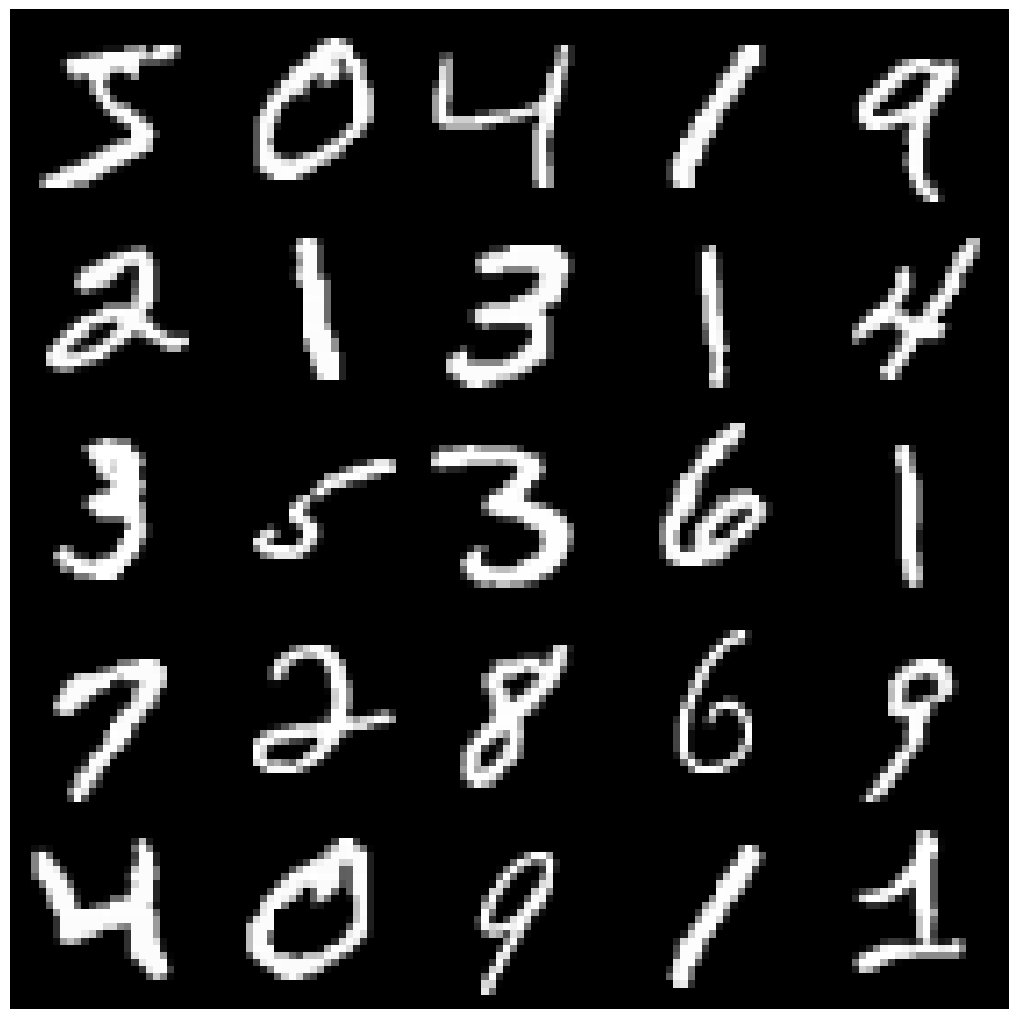

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

#train_dataset = mnist_trainset.data[0:500].reshape(-1, 1, 28, 28) / 255.
train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
#eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(train_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

print(train_dataset.shape)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
      super().__init__()
      #encoding
      self.in_lay=nn.Linear(input_dim,1600)
      self.enclay1=nn.Linear(1600,800)
      self.mu=nn.Linear(800,latent_dim)
      self.logstd=nn.Linear(800,latent_dim)

      #deocoding
      self.declay1=nn.Linear(latent_dim,800)
      self.declay2=nn.Linear(800,1600)
      self.out_lay=nn.Linear(1600,input_dim)

      self.relu=nn.ReLU()

    def encode(self,x):
        el1=self.relu(self.in_lay(x))
        el2=self.relu(self.enclay1(el1))
        mu=self.mu(el2)
        logstd=self.logstd(el2)

        return mu, logstd

    def decode(self, z):
        dl1=self.relu(self.declay1(z))
        dl2=self.relu(self.declay2(dl1))

        return torch.sigmoid(self.out_lay(dl2))

    def forward(self,x):
        mu, logstd = self.encode(x)
        std=torch.exp(logstd)
        eps = torch.randn_like(logstd)
        z_reparam = mu + std*eps
        z_prior = torch.randn_like(logstd)
        x_recon = self.decode(z_reparam)

        return x_recon, mu, logstd, z_prior, z_reparam

In [ ]:
def loss_function(x, x_recon, mu, logstd, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior):
    recon_loss=F.mse_loss(x_recon.reshape(x.shape[0],-1),x.reshape(x.shape[0],-1),reduction='sum')
    kl_div = -0.5*torch.sum(1+logstd-mu.pow(2)-(torch.exp(logstd)).pow(2))

    def imq_kernel(z1,z2):
        Cbase = (2* latent_dim * kernel_bandwidth**2)
        k =0
        for scale in scales:
            C=scale*Cbase

            k+= C/(C + torch.norm(z1.unsqueeze(1)-z2.unsqueeze(0),dim=-1) ** 2)
        return k

    k_z=imq_kernel(z_reparam,z_reparam)
    k_z_prior=imq_kernel(z_prior,z_prior)
    k_cross=imq_kernel(z_reparam,z_prior)

    mmd_z=(k_z - k_z.diag().diag()).sum()/((n-1)*n)
    mmd_z_prior=(k_z_prior-k_z_prior.diag().diag()).sum()/((n-1)*n)
    mmd_cross=k_cross.sum()/(n**2)
    mmd_loss=mmd_z+mmd_z_prior-2*mmd_cross

    return recon_loss, kl_div, mmd_loss

In [ ]:
def train(config=None):
    wandb.init(config = config)
    config=wandb.config

    input_dim=784
    latent_dim=config.latent_dim
    num_epochs=config.num_epochs
    batch_size=config.batch_size
    learning_rate=config.learning_rate
    alpha=config.alpha
    lbd=config.lbd
    scales = [0.1, 0.2, 0.5, 1.0, 2.0, 5, 10.0]
    kernel_bandwidth=1

    #dataset
    train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size)
    model=VariationalAutoEncoder(input_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    z_star=[]

    #train
    for epoch in range(num_epochs):
        loop=tqdm(enumerate(train_loader))
        batch_mu1=[]
        batch_mu2=[]
        batch_logstd1=[]
        batch_logstd2=[]

        for i, x in loop:
            x=x.to(device).view(x.shape[0],input_dim)
            x_recon, mu, logstd, z_prior, z_reparam =model(x)
            n=z_reparam.shape[0]
            z_star.append(z_reparam.detach())
            batch_mu1.append(mu[0:16,0].detach())
            batch_mu2.append(mu[0:16,1].detach())
            batch_logstd1.append(mu[0:16,0].detach())
            batch_logstd2.append(mu[0:16,1].detach())

            recon_loss, kl_div, mmd_loss=loss_function(x, x_recon, mu, logstd, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior)

            #batch_recon.append(recon_loss)
            #batch_kl_div.append(kl_div)
            #batch_mmd.append(mmd_loss)

        #epoch_recon=torch.mean(torch.stack(batch_recon))
        #epoch_kl_div=torch.mean(torch.stack(batch_kl_div))
        #epoch_mmd=torch.mean(torch.stack(batch_mmd))

            loss= recon_loss + (1-alpha)*kl_div + (alpha + lbd -1)*mmd_loss

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

            wandb.log({'loss':loss,'epoch':epoch,'recon loss':recon_loss,'kl diverg':kl_div,'mmd loss':mmd_loss})

    mu1=torch.mean(torch.stack(batch_mu1))
    mu2=torch.mean(torch.stack(batch_mu2))
    logstd1=torch.exp(torch.mean(torch.stack(batch_logstd1)))
    logstd2=torch.exp(torch.mean(torch.stack(batch_logstd2)))
    d=torch.zeros(1).to(device)
    z1star=[]
    z2star=[]

    for i in range(16):
        std1=torch.exp(logstd1)
        eps1=torch.randn_like(d)
        z1=mu1+eps1*logstd1
        z1star.append(z1)

        std2=torch.exp(logstd2)
        eps2=torch.randn_like(d)
        z2=mu2+eps2*logstd2
        z2star.append(z2)


    z1star=torch.stack(z1star).cpu().numpy().flatten()
    z2star=torch.stack(z2star).cpu().numpy().flatten()
    x=np.linspace(-4,4,100)
    y=np.linspace(-4,4,100)
    X,Y=np.meshgrid(x,y)
    positions = np.vstack([X.ravel(),Y.ravel()])
    values = np.vstack([z1star,z2star])
    kernel=gaussian_kde(values)
    Z=np.reshape(kernel(positions).T, X.shape)
    plt.figure(figsize=(6,6))
    plt.contourf(X,Y,Z, levels=15, cmap='Blues')
    plt.xticks([])
    plt.yticks([])


    run_name=wandb.run.name
    run_lat='latent space'
    run_lat_name=run_name+run_lat
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_lat_name}.png"
    plt.savefig(img_path)

    #Traversal of Latent Space
    n1=np.linspace(-3,3,18)
    n2=np.linspace(-3,3,18)
    store=[]

    for i in range(len(n1)):
        for j in range(len(n2)):
            z_trav=torch.zeros(latent_dim).to(device)
            z_trav[0]=n1[j]
            z_trav[1]=n2[i]
            trav_gen=model.decode(z_trav).detach()
            trav_gen_img=trav_gen.reshape(1,28,28)
            store.append(trav_gen_img)
    trav_imgs=torch.stack(store)

    fig2, axes2 =plt.subplots(nrows=(len(n1)), ncols=(len(n2)), figsize=(12,12))
    for i in range(len(n1)):
        for j in range(len(n2)):
            axes2[i][j].imshow(trav_imgs[i*18+j].cpu().squeeze(0), cmap='gray')
            axes2[i][j].axis('off')
    plt.tight_layout(pad=0.)

    run_trav='traversal'
    run_trav_name=run_name+run_trav
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_trav_name}.png"
    plt.savefig(img_path)

In [ ]:
wandb.agent(sweep_id, train, count=5)

Output hidden; open in https://colab.research.google.com to view.